# Create SBML model from BioCRNpyler

In [1]:
try:
    from biocrnpyler import * 
    #Here are some parameters loaded into default_parameters.txt
    #Promoter Names: strong, medium, weak correspond to bicistronic RBSs: BCD2, BCD8 and BCD12
    #RBS Names: strong, medium, Weak correspond to Anderson Promoters: J23100, J23106, and J23103
    G = DNAassembly("X", promoter = "strong", rbs = "weak", transcript = None, protein = None)
    #Also notice that the names of transcript and protein can be changed, or set to Species.
    x0_dict = {"protein_RNAP_machinery":10., "protein_RNAase_machinery":5.0, "protein_Ribo_machinery":50.,
                   'dna_X':0.5, 'dna_cellular_processes':0.01}
    model_txtl = TxTlDilutionMixture("txtl", components = [G], parameter_file = "default_parameters.txt",
                                    initial_condition_dictionary = x0_dict)

    CRN = model_txtl.compile_crn()
    print(repr(CRN),"\n", CRN.pretty_print(show_attributes = True, show_material = True, show_rates = True),"\n\n")
    # except:
    #     print('BioCRNpyler not found. To run this notebook, make sure you run pip install biocrnpyler first.')
    CRN.write_sbml_file('biocrnpyler_gene_expression.xml')
except:
    print('BioCRNpyler not found. To run this notebook make sure you run pip install biocrpyler first.')

Species = dna_X, protein_RNAP_machinery, rna_X, complex_dna_X_protein_RNAP_machinery_, protein_Ribo_machinery, protein_X, complex_protein_Ribo_machinery_rna_X_, protein_RNAase_machinery, dna_cellular_processes, rna_cellular_processes, complex_dna_cellular_processes_protein_RNAP_machinery_, protein_cellular_processes, complex_protein_Ribo_machinery_rna_cellular_processes_, complex_protein_RNAase_machinery_rna_X_, complex_complex_protein_Ribo_machinery_rna_X__protein_RNAase_machinery_, complex_protein_RNAase_machinery_rna_cellular_processes_, complex_complex_protein_Ribo_machinery_rna_cellular_processes__protein_RNAase_machinery_
Reactions = [
	dna[X]+protein[RNAP(machinery)] <--> complex[dna[X]:protein[RNAP]]
	complex[dna[X]:protein[RNAP]] --> dna[X]+rna[X]+protein[RNAP(machinery)]
	rna[X]+protein[Ribo(machinery)] <--> complex[protein[Ribo]:rna[X]]
	complex[protein[Ribo]:rna[X]] --> rna[X]+protein[X]+protein[Ribo(machinery)]
	dna[cellular_processes]+protein[RNAP(machinery)] <--> complex

C:\Users\Ayush\anaconda3\lib\site-packages\biocrnpyler\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from autoreduce import *
import numpy as np
from sympy import symbols

In [4]:
from autoreduce.converters import load_sbml
sys = load_sbml('biocrnpyler_gene_expression.xml', outputs = ['protein_X'])

In [14]:
for x, x_ic in x0_dict.items():
    curr_ind = sys.x.index(Symbol(x))
    sys.x_init[curr_ind] = x_ic

# Create and solve the ODE for the model

Text(0.5, 0, 'Time')

Text(0, 0.5, '[Outputs]')

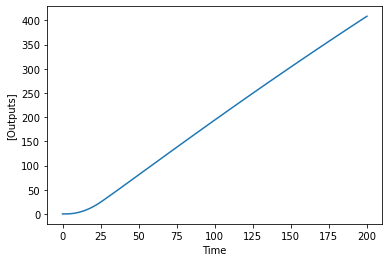

In [16]:
from autoreduce.utils import get_ODE
timepoints_ode = np.linspace(0, 200, 100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
try:
    import matplotlib.pyplot as plt
    plt.plot(timepoints_ode, np.transpose(np.array(sys.C)@sol))
    plt.xlabel('Time')
    plt.ylabel('[Outputs]')
    plt.show()
except:
    print('Plotting libraries missing.')

# Local sensitivity analysis for BioCRNpyler model

In [17]:
from autoreduce.utils import get_SSM
timepoints_ssm = np.linspace(0,20,10)
sys_ssm = get_SSM(sys, timepoints_ssm)
# Uncomment to run
# Ss = sys_ssm.compute_SSM() # len(timepoints) x len(params) x len(states)

In [18]:
# out_Ss = []
# for i in range(len(P)):
#     out_Ss.append((np.array(C)@(Ss[:,i,:].T)))
# out_Ss = np.reshape(np.array(out_Ss), (len(timepoints_ssm), len(P), 1))

# Plot heatmap for sensitivity analysis

In [19]:
# try:
    # import seaborn as sn
    # import matplotlib.pyplot as plt
    # for j in range(1):
    #     sn.heatmap(out_Ss[:,:,j].T)
    #     plt.xlabel('Time')
    #     plt.ylabel('Parameters')
    #     plt.title('Sensitivity of output[{0}] with respect to all parameters'.format(j))
    #     plt.show()
# except:
#     print('Plotting libraries missing.')

# Model reduction starts here:

In [22]:
from autoreduce.utils import get_reducible
timepoints_ssm = np.linspace(0,20,10)
sys_reduce.nstates_tol_min = 3 # Minimum number of states tbat you want in the reduced model

# Conservation Laws (if any)

In [11]:
G, P, C1, T, R, C2, E, C3, X = sys.x
conserved_quantities = [P + C1 - P_tot, R + C2 - R_tot, E + C3 - E_tot]
states_to_eliminate = [1,4,6]
f_cons = sys_reduce.solve_conservation_laws(conserved_quantities, states_to_eliminate)

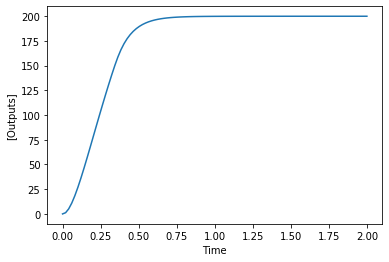

In [12]:
# from autoreduce.utils import get_ODE
# timepoints_ode = np.linspace(0, 2, 100)
# params_values = [100, 10, 4, 10, 0.25, 2, 10, 0.5, 1, 10, 1000, 1000, 1000]
# sys_reduce.params_values = params_values
# sys_ode = get_ODE(sys_reduce, timepoints_ode)
# sol = sys_ode.solve_system().T
# try:
    # import matplotlib.pyplot as plt
    # plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol))
    # plt.xlabel('Time')
    # plt.ylabel('[Outputs]')
    # plt.show()
# except:
#     print('Plotting libraries missing.')

# Derive model with no intermediate complexes

In [44]:
# states_to_remove = [x[12], x[12], x[14], x[15], x[16]]
# retained_states = []
# for state in x:
#     index = sys.x.index(state)
#     if state not in states_to_remove:
#         retained_states.append(x[index])
reduced_sys, fast_ss = sys_reduce.solve_timescale_separation([x[0], x[1], x[2], x[3], x[4], x[5], 
                                                             x[6], x[7], x[8], x[9], x[10], x[11]],
                                                             debug = False)
# reduced_sys.f[1]
# Se = sys_reduce.get_robustness_metric(reduced_sys, fast_ss, [0,2,5])

count 1
Successful time-scale separation solution obtained with states: [dna_X, protein_RNAP_machinery, rna_X, complex_dna_X_protein_RNAP_machinery_, protein_Ribo_machinery, protein_X, complex_protein_Ribo_machinery_rna_X_, protein_RNAase_machinery, dna_cellular_processes, rna_cellular_processes, complex_dna_cellular_processes_protein_RNAP_machinery_, protein_cellular_processes]!


In [43]:
reduced_sys.f

[complex_dna_X_protein_RNAP_machinery_*ktx_strong_ + complex_dna_X_protein_RNAP_machinery_*ku_strong_ - dna_X*kb__*protein_RNAP_machinery,
 complex_dna_X_protein_RNAP_machinery_*ktx_strong_ + complex_dna_X_protein_RNAP_machinery_*ku_strong_ + complex_dna_cellular_processes_protein_RNAP_machinery_*ktx__transcription + complex_dna_cellular_processes_protein_RNAP_machinery_*ku__transcription - dna_X*kb__*protein_RNAP_machinery - dna_cellular_processes*kb__transcription*protein_RNAP_machinery,
 complex_dna_X_protein_RNAP_machinery_*ktx_strong_ + complex_protein_Ribo_machinery_rna_X_*ktl__ + complex_protein_Ribo_machinery_rna_X_*ku_weak_ + kb__*ku__*protein_RNAase_machinery*rna_X/(kdeg__rna_degredation_mm + ku__) - kb__*protein_RNAase_machinery*rna_X - kb__*protein_Ribo_machinery*rna_X - kdil__*rna_X,
 -complex_dna_X_protein_RNAP_machinery_*ktx_strong_ - complex_dna_X_protein_RNAP_machinery_*ku_strong_ + dna_X*kb__*protein_RNAP_machinery,
 complex_protein_Ribo_machinery_rna_X_*kb__*kdeg__rn